In [ ]:
# Exporting the notebook. It may take several seconds....

[NbConvertApp] Converting notebook Nasa_turbo-PM-updated.ipynb to script
[NbConvertApp] Writing 6773 bytes to Nasa_turbo-PM-updated.py


seaborn==0.9.0
tensorflow==2.3.1
numpy==1.18.5
matplotlib==3.0.2
xgboost==1.2.1
Keras==2.4.3
autofeat==1.1.3
pandas==0.25.3
scikit_learn==0.23.2


INFO: Successfully output requirements


In [28]:
## $xpr_param_component_name = data_fetch
## $xpr_param_component_type = pipeline_job

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import keras
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

In [30]:
## $xpr_param_component_name = data_prep
## $xpr_param_component_type = pipeline_job

In [31]:
path = "/home/jovyan/predictive_maintenance/pipelines/pm-pipeline"
train_files = ['train_FD001.txt']
train_file = train_files[0]

In [32]:
def data_extraction(file):
    df = pd.read_csv(os.path.join(path, file), sep = ' ', header = None)
    print("Shape of training data: ",df.shape)
    return df

In [33]:
def data_cleaning(dataframe):
    dataframe_modified = dataframe.drop(dataframe.columns[[26, 27]], axis = 1) # dropping last two NaN columns
    dataframe_modified.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    
    # Calculating the RUL (Remaining Useful Life) for each id
    rul = pd.DataFrame(dataframe_modified.groupby('id')['cycle'].max()).reset_index() # max cycles for each id
    rul.columns = ['id', 'maxCycles'] 
    train_df = dataframe_modified.merge(rul, on=['id'], how='left') 
    train_df['RUL'] = train_df['maxCycles'] - train_df['cycle']
    train_df.drop('maxCycles', axis=1, inplace=True) 
    return train_df

In [34]:
## $xpr_param_component_name = data_transformation
## $xpr_param_component_type = pipeline_job

In [35]:
def create_training_and_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    return X_train, X_test, y_train, y_test

In [36]:
def normalization(X_train, X_test):
    scaler = QuantileTransformer(n_quantiles=10, output_distribution='normal')
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized, X_test_normalized

In [37]:
## $xpr_param_component_name = feature_engineering
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_file"]
## $xpr_param_global_methods = ["create_training_and_test_data", "normalization"]

In [38]:
def feature_engineering(dataframe):
    dataframe_description = dataframe.describe()
    df_plot = dataframe.copy()
    df_corr = df_plot.corr(method='pearson')
    fig, ax = plt.subplots(figsize=(10,10))
    axes = sns.heatmap(df_corr, linewidths=.2)
    axes = dataframe_description.T.plot.bar(subplots=True, figsize=(20,15))
    data = dataframe.drop(['cycle','id'], axis=1)
    
    X = (data.iloc[:,:-1]).to_numpy()
    y = (data.iloc[:,-1]).to_numpy()
    
    #Creating training and test data
    X_train, X_test, y_train, y_test = create_training_and_test_data(X, y)
    
    #Normalizing train and test data
    X_train_normalized, X_test_normalized = normalization(X_train, X_test)
    
    #Feature Engineering using autofeat
    afreg = AutoFeatRegressor(verbose=1, feateng_steps = 2, featsel_runs = 1)
    X_train_transformed = afreg.fit_transform(X_train_normalized, y_train)
    X_test_transformed = afreg.transform(X_test_normalized)
    print("R^2 after feature engineering: %.4f" % afreg.score(X_test_transformed, y_test))  
    X_train_transformed = X_train_transformed.to_numpy()
    X_test_transformed = X_test_transformed.to_numpy()
    return X_train_transformed, X_test_transformed, y_train, y_test

In [39]:
## $xpr_param_component_name = training
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_file"]
## $xpr_param_global_methods = ["feature_engineering", "data_extraction", "data_cleaning"]

In [40]:
def LSTM_model(X_train_normalized, y_train, X_test_normalized, y_test):
    # Defining a 2-layer stacked LSTM
    X_train_lstm = np.reshape(X_train_normalized,(X_train_normalized.shape[0],1,-1)) 
    print("Shape of X_train = "+str(X_train_lstm.shape))
    X_test_lstm = np.reshape(X_test_normalized,(X_test_normalized.shape[0],1,-1))
    print("Shape of X_train = "+str(X_test_lstm.shape))
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(1, X_train_normalized.shape[1]), return_sequences = True))
    model.add(LSTM(32, activation='relu', input_shape=(1, X_train_normalized.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train, epochs=20, validation_split=0.20)
    y_test_pred_lstm = model.predict(X_test_lstm)
    R2_test_lstm = r2_score(y_test_pred_lstm, y_test)
    print("\nR2 Score on the test dataset with LSTM = " + str(R2_test_lstm))
#     if not os.path.exists(self.OUTPUT_DIR):
#              os.makedirs(self.OUTPUT_DIR)
#     model.save(os.path.join(self.OUTPUT_DIR, 'lstm_model.h5'))
#     model.save("Model/lstm_model")
#     reconstructed_model = keras.models.load_model("Model/lstm_model")
    return model, R2_test_lstm

In [41]:
#     if not os.path.exists(self.OUTPUT_DIR):
#             os.makedirs(self.OUTPUT_DIR)
#     model.save(os.path.join(self.OUTPUT_DIR, 'saved_model.h5'))
#     logging.info("Saved model... load model")
#     self.report_status(status={"status": {"status": "Training completed"}})
#     super().completed(push_exp=True)

In [42]:
# Extracting data
df_initial = data_extraction(train_file)

Shape of training data:  (20631, 28)


In [43]:
# Removing columns with NaN and adding the RUL column
df_cleaned = data_cleaning(df_initial)
df_cleaned.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...      s13      s14     s15   s16  s17   s18    s19    s20  \
0  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

       s21  RUL  
0  23.4190  191  
1  23.4236  190  
2  23.3442  189  
3  23.3739  188  
4  23.4044  187  

[5 rows x 27 columns]

[AutoFeat] The 2 step feature engineering process could generate up to 14196 features.
[AutoFeat] With 16504 data points this new feature matrix would use about 0.94 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 74 transformed features from 24 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 4104 feature combinations from 4753 original feature tuples - done.
[feateng] Generated altogether 4782 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 3958 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/1
[featsel] 43 features after 1 feature selection runs
[featsel] 43 features after correlation filtering
[featsel] 42 features after noise filtering
[AutoFeat] Computing 30 new features.
[AutoFeat]    30/   30 new features ...done.
[AutoFeat] Final dataframe with 54 feature columns (30 new

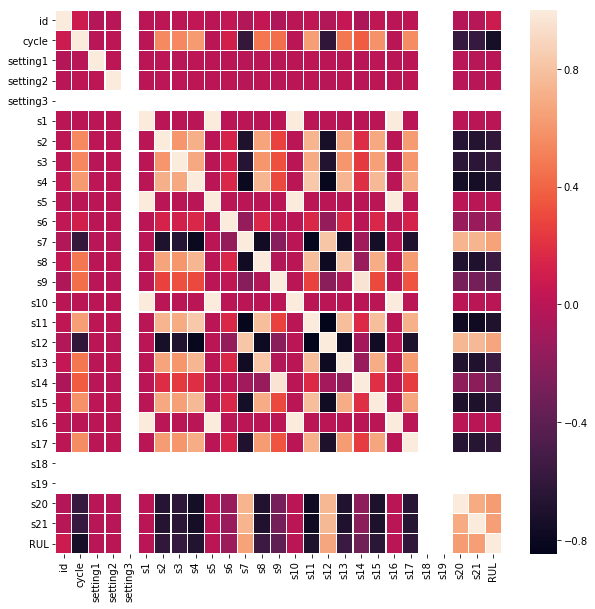

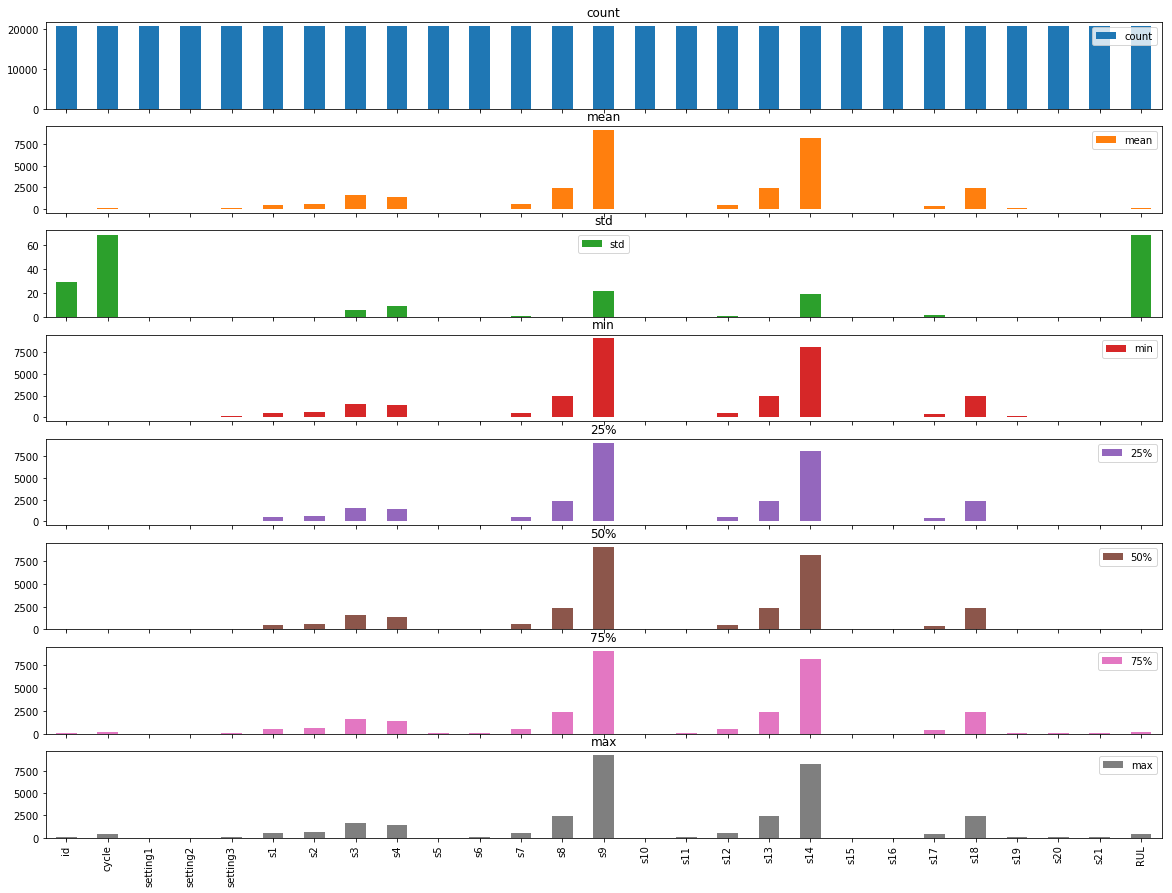

In [44]:
# Train-test split, normalization and feature engineering
X_train_transformed, X_test_transformed, y_train, y_test = feature_engineering(df_cleaned)

In [45]:
# # Fitting Random Forest model
# print("1. Using Random Forest:\n")
# model_ML, R2_test_ML = ML_model(X_train_transformed, y_train, X_test_transformed, y_test)

# Fitting LSTM model
print("2. Using LSTM:\n")
model_lstm, R2_test_lstm = LSTM_model(X_train_transformed, y_train, X_test_transformed, y_test)

2. Using LSTM:

Shape of X_train = (16504, 1, 54)
Shape of X_train = (4127, 1, 54)
Epoch 1/20
413/413 [==============================] - 2s 4ms/step - loss: 4187.8867 - val_loss: 1703.2581
Epoch 2/20
413/413 [==============================] - 1s 3ms/step - loss: 1749.7964 - val_loss: 1667.7145
Epoch 3/20
413/413 [==============================] - 1s 3ms/step - loss: 1726.9540 - val_loss: 1662.4258
Epoch 4/20
413/413 [==============================] - 2s 4ms/step - loss: 1720.1152 - val_loss: 1692.2023
Epoch 5/20
413/413 [==============================] - 2s 4ms/step - loss: 1714.6080 - val_loss: 1652.2673
Epoch 6/20
413/413 [==============================] - 1s 3ms/step - loss: 1707.7253 - val_loss: 1663.6946
Epoch 7/20
413/413 [==============================] - 1s 3ms/step - loss: 1704.7097 - val_loss: 1670.3901
Epoch 8/20
413/413 [==============================] - 2s 4ms/step - loss: 1702.8188 - val_loss: 1663.8231
Epoch 9/20
413/413 [==============================] - 1s 3ms/step - l